# Evolutionary Algorithms in Brain Microstructure Modeling

## Magnetic Resonance Imaging (MRI)

MRI allows to acquire images of living tissue, e.g. human brain. Typically, every image voxel represents a cubic volume of dimensions from 1x1x1 [mm] to 2x2x2 [mm], depending on MRI scanner parameters. Such resolution allows for instance to delineate grey and white matter tissue, as illustrated below.
<br /><br />

<div align="center">
   <img src="hcp_sample_t1.png" width="80%" />
   sample T1-weighted image,
   <em>source: Human Connectome Project</em>
</div>
<br />

<strong>Grey matter</strong> comprises of densely packed neuronal bodies, whereas <strong>white matter</strong> is formed of axons and dendrites aligned in fiber bundles. The bundles play a role of neuronal connections between distant grey matter areas, resembling a network of "highways" inside the brain.
<br /><br />

<div align="center">
   <img src="white_matter_tracts.png" width="80%" />
   sample white matter tracts,
   <em>source: https://radiologykey.com/white-matter-tracts/</em>
</div>

<br />

## Diffusion Weighted Imaging (DWI)

DWI is an imaging technique that captures mean displacement of water molecules in specified 3D directions, e.g. left-right, front-rear, top-bottom:
<br /><br />

<div align="center">
    <img src="hcp_sample_dwi.png" width="80%" />
    sample DWI-weighted images,
    <em>source: Human Connectome Project</em>    
</div>
<br />

Areas of <strong>high diffusivity</strong> are represented with darkest shades on diffusion weighted images. In the example above, the diffusivity in X direction (i.e. left-right) dominates the other two directions inside the highlighed region.
<br /><br />

We know (from physics and neuroanatomy) that water inside white matter "prefers" to diffuse along fibers rather than perpendicularly. With this in mind, DWI offers us an opportunity to capture anatomical features hidden below nominal imaging resolution. In particular, post processing of diffusion weighted images gives us spacial orientations of fibers inside each voxel containing white matter.
<br /><br />

<div align="center">
    <img src="ball_and_stick_fitted.png" width="60%" />
    orientations of fiber bundles in a sample region of white matter,
    <em>source: Human Connectome Project</em>    
</div>
<br />

Further postprocessing allows to obtain <strong>tractogram</strong> which is a color-coded map of neuronal connections inside the brain. Currently, tractograms are used both in research (e.g. neuroscience) and clinical practice (e.g. pre-surgical planning).
<br /><br />

<div align="center">
    <img src="tractogram.jpg" width="80%" />
    sample tractogram,
    <em>source: http://mcgovern.mit.edu/news/images/brain-scan-cover-image-summer-2013/</em>
</div>

<br />

## Microstructure modeling

In practice, diffusion signal is acquired from many directions and with various imaging settings. Protocols used by clinicians comprise of at least 32 images, whereas data sets processed by researchers contain even hundreds of diffusion weighted images per subject. Generally, the more images we have, the more exactly we can estimate microstructure features inside voxels. 
<br /><br />

<div align="center">
    <img src="dwi_imaging_directions.png" width="40%" />
    sample map of imaging directions,
    <em>source: http://www.emmanuelcaruyer.com/q-space-sampling.php</em>    
</div>
<br />

In order to process diffusion weighted images, we need a mathematical model that would fit the measured signal. One of the simplest models of this type is called <strong>Ball and Stick</strong>. The <em>ball</em> part of this model represents diffusion of extra-cellular water (that is not interesting for us now), whereas the <em>stick</em> part represents intra-cellular diffusion of water trapped inside axons.
<br /><br />

<div align="center">
    <img src="ball_and_stick_illustration.png" width="80%" />
    sample ball and stick configurations inside voxels
</div>
<br />

### Ball and Stick - formal definition

Let $M$ > 0 be the number of diffusion weighted images. For all $k = 1, ..., M$, the signal is modelled as
<br /><br />

<div align="center">
$S_k = S_0 \left[ f_{ball} \cdot \exp \left(-b_k \lambda_{iso} (\mathbf{g}_k^T \mathbf{v})^2 \right) + f_{stick} \cdot \exp(-b_k \lambda_{\parallel}) \right]$,
</div>

where:

- $f_{ball}, f_{stick} \in (0, 1)$ are weighing parameters of ball and stick fractions respectively, 
- $\lambda_{iso} \in \mathbb{R}$ is an isotropic diffusivity (inside the ball),
- $\lambda_{parallel} \in \mathbb{R}$ is a parallel diffusivity (inside the stick),
- $v = [\sin\mu_1 \cos\mu_2, \sin\mu_1 \sin\mu_2, \cos\mu_1]^T$ is a stick direction with $\mu = (\mu_1, \mu_2) \in [0, \pi] \times [0, 2\pi)$.
- $S_0$ is the signal acquired without diffusion sensitizing gradient (given),
- $\mathbf{g_k} \in \mathbb{R}_+^3$ and $b_k \in \mathbb{R}_+$ are the acquisition parameters (given).


## Simple example

The source code of this example requires <strong>dmipy</strong> module https://github.com/AthenaEPI/dmipy with its dependencies:
- numpy >= 1.13
- scipy
- dipy
- nibabel
- cvxpy
- fury


In [1]:
%%time

import nibabel as nib
import numpy as np
import numpy.matlib

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg
%matplotlib inline

import dmipy.data.saved_acquisition_schemes as saved_acquisition_schemes

from dmipy.signal_models import cylinder_models, gaussian_models
from dmipy.core.modeling_framework import MultiCompartmentModel
from dmipy.core.fitted_modeling_framework import FittedMultiCompartmentModel

from dipy.viz import window, actor

import tqdm

import warnings
warnings.filterwarnings("ignore")

CPU times: user 1.51 s, sys: 159 ms, total: 1.67 s
Wall time: 4.01 s


In [2]:
import numba
import pathos

First, we load a sample slice of DWI data from the Human Connectome Project repository: https://www.humanconnectome.org/

In [3]:
data_hcp = nib.load('wu_minn_hcp_coronal_slice.nii.gz').get_data()
scheme_hcp = saved_acquisition_schemes.wu_minn_hcp_acquisition_scheme()

We define a rectangular Region Of Interest (ROI):

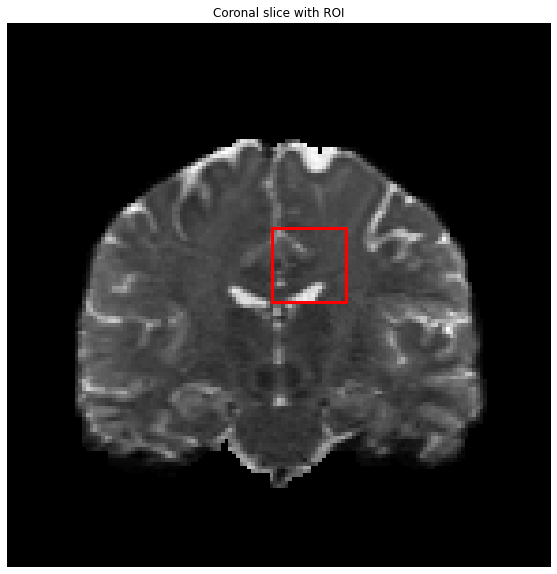

In [4]:
roi = {'x': 70, 'y': 70, 'width': 20, 'height': 20}
data_hcp_roi = data_hcp[
    roi['x'] : roi['x'] + roi['width'], :, roi['y'] : roi['y'] + roi['height']
]

fig, ax = plt.subplots(figsize=[10, 10])
ax.imshow(data_hcp[:, 0, :, 0].T, origin='lower', cmap='gray', interpolation='nearest')

rect = patches.Rectangle(
    (roi['x'], roi['y']), roi['width'], roi['height'], 
    linewidth = 3, edgecolor = 'r', facecolor = 'none'
)
ax.add_patch(rect)
ax.set_axis_off()
ax.set_title('Coronal slice with ROI');

Next, we create an instance of the Ball and Stick diffusion model.

In [5]:
ball = gaussian_models.G1Ball()
stick = cylinder_models.C1Stick()
bas_model = MultiCompartmentModel(models=[stick, ball])

Our model requires fitting the following five parameters for every image voxel:
- G1Ball_1_lambda_iso – extra-cellular diffusivity coefficient (real value * $10^{-9}$),
- C1Stick_1_mu – direction of a stick (2-dimensional real vector of sphere coordinates),
- C1Stick_1_lambda_par – intra-cellular diffusivity coefficient (real value * $10^{-9}$),
- partial_volume_0 – weight of the intra-cellular diffusion fraction (real value),
- partial_volume_1 – weight of the extra-cellular diffusion fraction (real value).

The ranges of parameters are given below:

In [6]:
bas_model.parameter_ranges

OrderedDict([('C1Stick_1_mu',
              ([0, 3.141592653589793],
               [-3.141592653589793, 3.141592653589793])),
             ('C1Stick_1_lambda_par', (0.1, 3)),
             ('G1Ball_1_lambda_iso', (0.1, 3)),
             ('partial_volume_0', (0.01, 0.99)),
             ('partial_volume_1', (0.01, 0.99))])

### Dummy solution

Let's try setting random parameters to our Ball and Stick model.

In [7]:
def set_parameters(our_voxel_bas_model, scheme_hcp, voxel_signal):
    params = []

    # estimate S0
    our_voxel_bas_model.scheme = scheme_hcp
    S0 = np.mean(voxel_signal[scheme_hcp.b0_mask], axis=-1)
    
    # G1Ball_1_lambda_iso
    param_range = our_voxel_bas_model.parameter_ranges['G1Ball_1_lambda_iso']
    lambda_iso = np.random.uniform(param_range[0], param_range[1]) * 1e-09

    # C1Stick_1_mu
    param_ranges = our_voxel_bas_model.parameter_ranges['C1Stick_1_mu']
    mu_1 = np.random.uniform(param_ranges[0][0], param_ranges[0][1])
    mu_2 = np.random.uniform(param_ranges[1][0], param_ranges[1][1])
    
    # C1Stick_1_lambda_par
    param_range = our_voxel_bas_model.parameter_ranges['C1Stick_1_lambda_par']
    lambda_parallel = np.random.uniform(param_range[0], param_range[1]) * 1e-09
    
    # partial_volume_0
    param_range = our_voxel_bas_model.parameter_ranges['partial_volume_0']
    f_stick = np.random.uniform(param_range[0], param_range[1])
    
    # partial_volume_1
    param_range = our_voxel_bas_model.parameter_ranges['partial_volume_1']
    f_ball = np.random.uniform(param_range[0], param_range[1])
            
    return FittedMultiCompartmentModel(
        our_voxel_bas_model, np.array(S0), np.array([True]), 
        np.array([[mu_1, mu_2, lambda_iso, lambda_parallel, f_stick, f_ball]])
    )

our_bas_model = {}
voxel_mse = np.zeros([roi['width'], roi['height']])

for x in range(roi['width']):
    our_bas_model[x] = {}
    for y in range(roi['height']):
        
        voxel_signal = data_hcp_roi[x, 0, y, :]
        our_bas_model[x][y] = set_parameters(bas_model, scheme_hcp, voxel_signal)
        
        voxel_mse[x][y] = our_bas_model[x][y].mean_squared_error(voxel_signal)
          
print("Fitting accuracy:")        
print("MSE +/- STD = %f +/- %f" % (np.mean(voxel_mse), np.std(voxel_mse)))

Fitting accuracy:
MSE +/- STD = 0.107650 +/- 0.114778


The mean squared errors are relatively high and dispersed. The orientations of fiber bundles (red lines) and volumes of intra-cellular diffusion (grayscale shades) look random on a visualization below.

our randomized model:


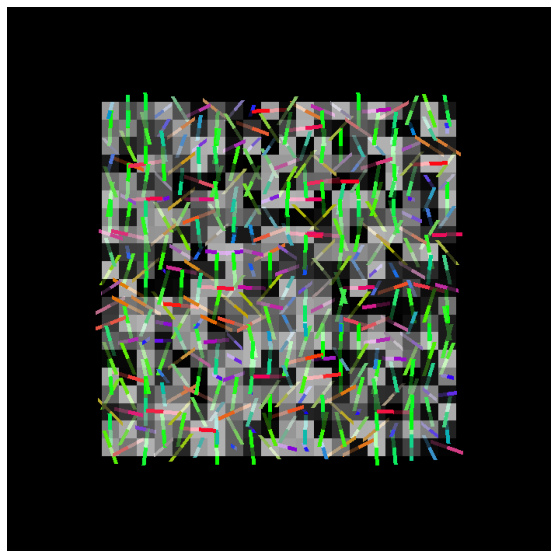

In [8]:
def visualize_result(bas_models_fit):

    affine = np.eye(4)
    affine[0,3] = -10
    affine[1,3] = -10

    volume = np.zeros([roi['width'], roi['height'], 1])
    peak_dirs = np.zeros([roi['width'], roi['height'], 1, 1, 3])

    for x in range(roi['width']):
        for y in range(roi['height']):
            volume[x, y, 0] = bas_models_fit[x][y].fitted_parameters['partial_volume_0']
            peak_cart = np.squeeze(bas_models_fit[x][y].peaks_cartesian())
            peak_dirs[x, y, 0] = [peak_cart[0], peak_cart[2], -peak_cart[1]]

    ren = window.ren()
    ren.add(actor.slicer(volume, interpolation='nearest', affine=affine, opacity=0.7))
    ren.add(actor.peak_slicer(peak_dirs, None, affine=affine, linewidth=5, colors=None))   

    window.record(ren, size=[700, 700], out_path='dipy.png')
    
    img = mpimg.imread('dipy.png')
    plt.figure(figsize=[10, 10])
    plt.imshow(img) #[100:-97, 100:-85])
    plt.axis('off');
    
print("our randomized model:")
visualize_result(our_bas_model)

### State-of-the-art solution

For comparison, let's try now a state-of-the-art solution.

In [9]:
%%time
reference_bas_model = {}
voxel_mse = np.zeros([roi['width'], roi['height']])

for x in range(roi['width']):
    reference_bas_model[x] = {}
    for y in range(roi['height']):
        
        voxel_signal = data_hcp_roi[x, 0, y, :]
        reference_bas_model[x][y] = bas_model.fit(scheme_hcp, voxel_signal)
        
        voxel_mse[x][y] = reference_bas_model[x][y].mean_squared_error(voxel_signal)
        
print("Fitting accuracy:")        
print("MSE +/- STD = %f +/- %f" % (np.mean(voxel_mse), np.std(voxel_mse)))

Using parallel processing with 1 workers.
Setup brute2fine optimizer in 0.49901294708251953 seconds
Fitting of 1 voxels complete in 1.3933689594268799 seconds.
Average of 1.3933689594268799 seconds per voxel.
Using parallel processing with 1 workers.
Setup brute2fine optimizer in 0.49755430221557617 seconds
Fitting of 1 voxels complete in 0.12096071243286133 seconds.
Average of 0.12096071243286133 seconds per voxel.
Using parallel processing with 1 workers.
Setup brute2fine optimizer in 0.5836293697357178 seconds
Fitting of 1 voxels complete in 0.12901997566223145 seconds.
Average of 0.12901997566223145 seconds per voxel.
Using parallel processing with 1 workers.
Setup brute2fine optimizer in 0.5160441398620605 seconds
Fitting of 1 voxels complete in 0.10454845428466797 seconds.
Average of 0.10454845428466797 seconds per voxel.
Using parallel processing with 1 workers.
Setup brute2fine optimizer in 0.4445829391479492 seconds
Fitting of 1 voxels complete in 0.05571293830871582 seconds.


Setup brute2fine optimizer in 0.8889658451080322 seconds
Fitting of 1 voxels complete in 0.12949705123901367 seconds.
Average of 0.12949705123901367 seconds per voxel.
Using parallel processing with 1 workers.
Setup brute2fine optimizer in 0.4284181594848633 seconds
Fitting of 1 voxels complete in 0.0765986442565918 seconds.
Average of 0.0765986442565918 seconds per voxel.
Using parallel processing with 1 workers.
Setup brute2fine optimizer in 1.054227352142334 seconds
Fitting of 1 voxels complete in 0.1906287670135498 seconds.
Average of 0.1906287670135498 seconds per voxel.
Using parallel processing with 1 workers.
Setup brute2fine optimizer in 1.163201093673706 seconds
Fitting of 1 voxels complete in 0.1859450340270996 seconds.
Average of 0.1859450340270996 seconds per voxel.
Using parallel processing with 1 workers.
Setup brute2fine optimizer in 1.1487364768981934 seconds
Fitting of 1 voxels complete in 0.09484481811523438 seconds.
Average of 0.09484481811523438 seconds per voxel.


Using parallel processing with 1 workers.
Setup brute2fine optimizer in 0.635800838470459 seconds
Fitting of 1 voxels complete in 0.08873820304870605 seconds.
Average of 0.08873820304870605 seconds per voxel.
Using parallel processing with 1 workers.
Setup brute2fine optimizer in 0.5296015739440918 seconds
Fitting of 1 voxels complete in 0.08358168601989746 seconds.
Average of 0.08358168601989746 seconds per voxel.
Using parallel processing with 1 workers.
Setup brute2fine optimizer in 0.9775617122650146 seconds
Fitting of 1 voxels complete in 0.18410468101501465 seconds.
Average of 0.18410468101501465 seconds per voxel.
Using parallel processing with 1 workers.
Setup brute2fine optimizer in 0.9662532806396484 seconds
Fitting of 1 voxels complete in 0.1514604091644287 seconds.
Average of 0.1514604091644287 seconds per voxel.
Using parallel processing with 1 workers.
Setup brute2fine optimizer in 0.8934187889099121 seconds
Fitting of 1 voxels complete in 0.1269381046295166 seconds.
Aver

Setup brute2fine optimizer in 0.47919440269470215 seconds
Fitting of 1 voxels complete in 0.12919855117797852 seconds.
Average of 0.12919855117797852 seconds per voxel.
Using parallel processing with 1 workers.
Setup brute2fine optimizer in 0.404630184173584 seconds
Fitting of 1 voxels complete in 0.10388374328613281 seconds.
Average of 0.10388374328613281 seconds per voxel.
Using parallel processing with 1 workers.
Setup brute2fine optimizer in 0.4330921173095703 seconds
Fitting of 1 voxels complete in 0.07871460914611816 seconds.
Average of 0.07871460914611816 seconds per voxel.
Using parallel processing with 1 workers.
Setup brute2fine optimizer in 0.7025716304779053 seconds
Fitting of 1 voxels complete in 0.12633562088012695 seconds.
Average of 0.12633562088012695 seconds per voxel.
Using parallel processing with 1 workers.
Setup brute2fine optimizer in 0.4219202995300293 seconds
Fitting of 1 voxels complete in 0.0903770923614502 seconds.
Average of 0.0903770923614502 seconds per v

Using parallel processing with 1 workers.
Setup brute2fine optimizer in 0.6690354347229004 seconds
Fitting of 1 voxels complete in 0.1430511474609375 seconds.
Average of 0.1430511474609375 seconds per voxel.
Using parallel processing with 1 workers.
Setup brute2fine optimizer in 0.6680662631988525 seconds
Fitting of 1 voxels complete in 0.15625286102294922 seconds.
Average of 0.15625286102294922 seconds per voxel.
Using parallel processing with 1 workers.
Setup brute2fine optimizer in 0.5772736072540283 seconds
Fitting of 1 voxels complete in 0.1433868408203125 seconds.
Average of 0.1433868408203125 seconds per voxel.
Using parallel processing with 1 workers.
Setup brute2fine optimizer in 0.6228811740875244 seconds
Fitting of 1 voxels complete in 0.08876514434814453 seconds.
Average of 0.08876514434814453 seconds per voxel.
Using parallel processing with 1 workers.
Setup brute2fine optimizer in 0.4643518924713135 seconds
Fitting of 1 voxels complete in 0.04541134834289551 seconds.
Aver

Setup brute2fine optimizer in 0.4303305149078369 seconds
Fitting of 1 voxels complete in 0.08070659637451172 seconds.
Average of 0.08070659637451172 seconds per voxel.
Using parallel processing with 1 workers.
Setup brute2fine optimizer in 0.7271671295166016 seconds
Fitting of 1 voxels complete in 0.08835268020629883 seconds.
Average of 0.08835268020629883 seconds per voxel.
Using parallel processing with 1 workers.
Setup brute2fine optimizer in 0.7179298400878906 seconds
Fitting of 1 voxels complete in 0.10025167465209961 seconds.
Average of 0.10025167465209961 seconds per voxel.
Using parallel processing with 1 workers.
Setup brute2fine optimizer in 0.4223670959472656 seconds
Fitting of 1 voxels complete in 0.0878901481628418 seconds.
Average of 0.0878901481628418 seconds per voxel.
Using parallel processing with 1 workers.
Setup brute2fine optimizer in 0.4153261184692383 seconds
Fitting of 1 voxels complete in 0.09544706344604492 seconds.
Average of 0.09544706344604492 seconds per v

Fitting of 1 voxels complete in 0.20417284965515137 seconds.
Average of 0.20417284965515137 seconds per voxel.
Using parallel processing with 1 workers.
Setup brute2fine optimizer in 0.5897860527038574 seconds
Fitting of 1 voxels complete in 0.1235508918762207 seconds.
Average of 0.1235508918762207 seconds per voxel.
Using parallel processing with 1 workers.
Setup brute2fine optimizer in 0.5703458786010742 seconds
Fitting of 1 voxels complete in 0.13996028900146484 seconds.
Average of 0.13996028900146484 seconds per voxel.
Using parallel processing with 1 workers.
Setup brute2fine optimizer in 0.8351125717163086 seconds
Fitting of 1 voxels complete in 0.0906212329864502 seconds.
Average of 0.0906212329864502 seconds per voxel.
Using parallel processing with 1 workers.
Setup brute2fine optimizer in 0.767268180847168 seconds
Fitting of 1 voxels complete in 0.14242839813232422 seconds.
Average of 0.14242839813232422 seconds per voxel.
Using parallel processing with 1 workers.
Setup brute2

Using parallel processing with 1 workers.
Setup brute2fine optimizer in 0.4451007843017578 seconds
Fitting of 1 voxels complete in 0.06152820587158203 seconds.
Average of 0.06152820587158203 seconds per voxel.
Using parallel processing with 1 workers.
Setup brute2fine optimizer in 0.45070791244506836 seconds
Fitting of 1 voxels complete in 0.0528109073638916 seconds.
Average of 0.0528109073638916 seconds per voxel.
Using parallel processing with 1 workers.
Setup brute2fine optimizer in 0.4485905170440674 seconds
Fitting of 1 voxels complete in 0.058687686920166016 seconds.
Average of 0.058687686920166016 seconds per voxel.
Using parallel processing with 1 workers.
Setup brute2fine optimizer in 0.45296788215637207 seconds
Fitting of 1 voxels complete in 0.05274176597595215 seconds.
Average of 0.05274176597595215 seconds per voxel.
Using parallel processing with 1 workers.
Setup brute2fine optimizer in 0.42560791969299316 seconds
Fitting of 1 voxels complete in 0.08106017112731934 second

Setup brute2fine optimizer in 0.5014927387237549 seconds
Fitting of 1 voxels complete in 0.1192009449005127 seconds.
Average of 0.1192009449005127 seconds per voxel.
Using parallel processing with 1 workers.
Setup brute2fine optimizer in 0.46479249000549316 seconds
Fitting of 1 voxels complete in 0.1433701515197754 seconds.
Average of 0.1433701515197754 seconds per voxel.
Using parallel processing with 1 workers.
Setup brute2fine optimizer in 0.43766117095947266 seconds
Fitting of 1 voxels complete in 0.06227517127990723 seconds.
Average of 0.06227517127990723 seconds per voxel.
Using parallel processing with 1 workers.
Setup brute2fine optimizer in 0.43227672576904297 seconds
Fitting of 1 voxels complete in 0.0723564624786377 seconds.
Average of 0.0723564624786377 seconds per voxel.
Using parallel processing with 1 workers.
Setup brute2fine optimizer in 0.42734432220458984 seconds
Fitting of 1 voxels complete in 0.08008933067321777 seconds.
Average of 0.08008933067321777 seconds per v

Using parallel processing with 1 workers.
Setup brute2fine optimizer in 0.42216062545776367 seconds
Fitting of 1 voxels complete in 0.08761739730834961 seconds.
Average of 0.08761739730834961 seconds per voxel.
Using parallel processing with 1 workers.
Setup brute2fine optimizer in 0.4566526412963867 seconds
Fitting of 1 voxels complete in 0.04935336112976074 seconds.
Average of 0.04935336112976074 seconds per voxel.
Using parallel processing with 1 workers.
Setup brute2fine optimizer in 0.4418814182281494 seconds
Fitting of 1 voxels complete in 0.06830620765686035 seconds.
Average of 0.06830620765686035 seconds per voxel.
Using parallel processing with 1 workers.
Setup brute2fine optimizer in 0.42615294456481934 seconds
Fitting of 1 voxels complete in 0.07787370681762695 seconds.
Average of 0.07787370681762695 seconds per voxel.
Using parallel processing with 1 workers.
Setup brute2fine optimizer in 0.42719507217407227 seconds
Fitting of 1 voxels complete in 0.07873058319091797 second

Using parallel processing with 1 workers.
Setup brute2fine optimizer in 0.4547243118286133 seconds
Fitting of 1 voxels complete in 0.05410289764404297 seconds.
Average of 0.05410289764404297 seconds per voxel.
Using parallel processing with 1 workers.
Setup brute2fine optimizer in 0.43831849098205566 seconds
Fitting of 1 voxels complete in 0.06980323791503906 seconds.
Average of 0.06980323791503906 seconds per voxel.
Using parallel processing with 1 workers.
Setup brute2fine optimizer in 0.4294900894165039 seconds
Fitting of 1 voxels complete in 0.07960772514343262 seconds.
Average of 0.07960772514343262 seconds per voxel.
Using parallel processing with 1 workers.
Setup brute2fine optimizer in 0.42667055130004883 seconds
Fitting of 1 voxels complete in 0.07964754104614258 seconds.
Average of 0.07964754104614258 seconds per voxel.
Using parallel processing with 1 workers.
Setup brute2fine optimizer in 0.481015682220459 seconds
Fitting of 1 voxels complete in 0.12870550155639648 seconds.

The MSEs and STDs are much lower than before. Also, the visualization of fiber bundles looks more realistic.

state-of-the-art model:


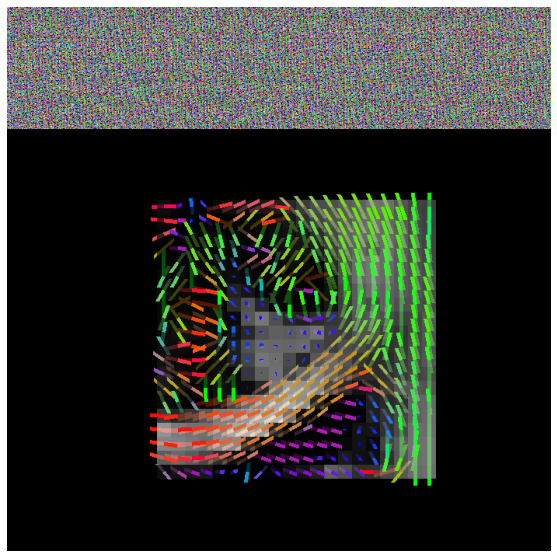

In [10]:
print("state-of-the-art model:")
visualize_result(reference_bas_model)

### Assignment

Use any optimization engine that you know (e.g. genetic algorithm) and compare your results with the state-of-the-art solution. 
- Can your solution produce more exact fitting? 
- Are the MSEs less dispersed?
- Does it work faster than the reference method?

## Algorithms that I want to try out:
- ES(1+1)
- ES(mi,lambda)
- ES(mi+lambda)
- CMA-ES

## Other approaches:
- whole ROI image as input
- each voxel of ROI as input
- decreasing mutation scope as time goes by, inspiration from simulated annealing
- comparison of only within-domain chromosomes and none-constrainted chromosomes with punishment when beyond bounds

Firstly I tried to use ES(mi+lambda) on full set of pixels.

In [11]:
def es(objective_function, chromosome_length, population_size, number_of_iterations, number_of_offspring, number_of_parents, sigma, tau, tau_0, log_frequency=1, R=None):

    best_solution = np.empty((1, chromosome_length))
    best_solution_objective_value = 1e10

    log_objective_values = np.empty((number_of_iterations, 4))
    log_best_solutions = np.empty((number_of_iterations, chromosome_length))
    
    def mut3(og):
        S = np.random.uniform(0,sigma, size=(chromosome_length, chromosome_length))
        S = np.dot(S,S.T)
        b = np.dot(np.random.randn(number_of_offspring, chromosome_length), np.linalg.cholesky(S).T)
        return og + b
    
    def in_domain(chrom, R):
        for p in range(len(chrom)):
            R_ind = p % 6
            if not R[R_ind][0] < chrom[p] < R[R_ind][1]:
                chrom[p] = np.random.uniform(R[R_ind][0],R[R_ind][1])
        return chrom
    
    def initial_population(population_size, R):
        current_population_solutions = np.zeros((population_size, chromosome_length))
        for pop in range(population_size):
            for p in range(chromosome_length):
                R_ind = p % 6
                current_population_solutions[pop][p] = np.random.uniform(R[R_ind][0],R[R_ind][1])
        return current_population_solutions
            
    
    mutation_f = mut3

    # generating an initial population
    current_population_solutions = initial_population(population_size, R)

    # evaluating the objective function on the current population
    current_population_objective_values = np.zeros(population_size)
    for i, guy in enumerate(current_population_solutions):
            current_population_objective_values[i] = objective_function(guy)

    for t in tqdm.tqdm(range(number_of_iterations)):

        # selecting the parent indices by the roulette wheel method
        fitness_values = current_population_objective_values - current_population_objective_values.min()
        if fitness_values.sum() > 0:
            fitness_values = fitness_values / fitness_values.sum()
        else:
            fitness_values = 1.0 / population_size * np.ones(population_size)
        parent_indices = np.random.choice(population_size, (number_of_offspring, number_of_parents), True, fitness_values).astype(np.int64)

        # creating the children population by Global Intermediere Recombination
        children_population_solutions = np.zeros((number_of_offspring, chromosome_length))
        
        for i in range(number_of_offspring):
            children_population_solutions[i, :] = current_population_solutions[parent_indices[i, :], :].mean(axis=0)

        # mutating the children population by adding random gaussian noise
        children_population_solutions = mutation_f(children_population_solutions)
        
        # check if in domain
        for chrom in children_population_solutions:
            chrom = in_domain(chrom, R)                
        
        # evaluating the objective function on the children population
        children_population_objective_values = np.zeros(len(children_population_solutions))
        for i, child in enumerate(children_population_solutions):
            children_population_objective_values[i] = objective_function(child)

        # replacing the current population by (Mu + Lambda) Replacement
        current_population_objective_values = np.hstack([current_population_objective_values, children_population_objective_values])
        current_population_solutions = np.vstack([current_population_solutions, children_population_solutions])

        I = np.argsort(-current_population_objective_values)[::-1]
        current_population_solutions = current_population_solutions[I[:population_size], :]
        current_population_objective_values = current_population_objective_values[I[:population_size]]

        # recording some statistics
        if best_solution_objective_value > current_population_objective_values[0]:
            best_solution = current_population_solutions[0]
            best_solution_objective_value = current_population_objective_values[0]
        log_objective_values[t, :] = [current_population_objective_values.min(), current_population_objective_values.max(), current_population_objective_values.mean(), current_population_objective_values.std()]
        log_best_solutions[t, :] = current_population_solutions[0, :]
        
    return best_solution_objective_value, best_solution, log_objective_values, log_best_solutions

In [12]:
def set_random_parameters(our_voxel_bas_model, scheme_hcp, voxel_signal):
    params = []

    # estimate S0
    our_voxel_bas_model.scheme = scheme_hcp
    S0 = np.mean(voxel_signal[scheme_hcp.b0_mask], axis=-1)
    
    # G1Ball_1_lambda_iso
    param_range = our_voxel_bas_model.parameter_ranges['G1Ball_1_lambda_iso']
    lambda_iso = np.random.uniform(param_range[0], param_range[1]) * 1e-09

    # C1Stick_1_mu
    param_ranges = our_voxel_bas_model.parameter_ranges['C1Stick_1_mu']
    mu_1 = np.random.uniform(param_ranges[0][0], param_ranges[0][1])
    mu_2 = np.random.uniform(param_ranges[1][0], param_ranges[1][1])
    
    # C1Stick_1_lambda_par
    param_range = our_voxel_bas_model.parameter_ranges['C1Stick_1_lambda_par']
    lambda_parallel = np.random.uniform(param_range[0], param_range[1]) * 1e-09
    
    # partial_volume_0
    param_range = our_voxel_bas_model.parameter_ranges['partial_volume_0']
    f_stick = np.random.uniform(param_range[0], param_range[1])
    
    # partial_volume_1
    param_range = our_voxel_bas_model.parameter_ranges['partial_volume_1']
    f_ball = np.random.uniform(param_range[0], param_range[1])
            
    return FittedMultiCompartmentModel(
        our_voxel_bas_model, np.array(S0), np.array([True]), 
        np.array([[mu_1, mu_2, lambda_iso, lambda_parallel, f_stick, f_ball]])
    )


def set_params_from_chrom(chrom, our_voxel_bas_model, scheme_hcp, voxel_signal):
    our_voxel_bas_model.scheme = scheme_hcp
    S0 = np.mean(voxel_signal[scheme_hcp.b0_mask], axis=-1)
    
    mu_1, mu_2 = chrom[0], chrom[1]
    lambda_parallel = chrom[2] * 1e-09
    lambda_iso = chrom[3] * 1e-09
    f_stick = chrom[4]
    f_ball = chrom[5]
    
    return FittedMultiCompartmentModel(
            our_voxel_bas_model, np.array(S0), np.array([True]), 
            np.array([[mu_1, mu_2, lambda_iso, lambda_parallel, f_stick, f_ball]])
    )

def objective_function(ch, bas_model, scheme_hcp, voxel_signal):
    new_chroms = ch.reshape((roi['width'], roi['height'], 6))
    
    our_bas_model = {}
    voxel_mse = np.zeros([roi['width'], roi['height']])

    for x in range(roi['width']):
        our_bas_model[x] = {}
        for y in range(roi['height']):

            voxel_signal = data_hcp_roi[x, 0, y, :]
            our_bas_model[x][y] = set_params_from_chrom(new_chroms[x][y], bas_model, scheme_hcp, voxel_signal)

            voxel_mse[x][y] = our_bas_model[x][y].mean_squared_error(voxel_signal)

    return np.mean(voxel_mse)

In [13]:
def set_params_from_chrom(chrom, our_voxel_bas_model, scheme_hcp, voxel_signal):
    our_voxel_bas_model.scheme = scheme_hcp
    S0 = np.mean(voxel_signal[scheme_hcp.b0_mask], axis=-1)
    
    mu_1, mu_2 = chrom[0], chrom[1]
    lambda_parallel = chrom[2] * 1e-09
    lambda_iso = chrom[3] * 1e-09
    f_stick = chrom[4]
    f_ball = chrom[5]
    
    return FittedMultiCompartmentModel(
            our_voxel_bas_model, np.array(S0), np.array([True]), 
            np.array([[mu_1, mu_2, lambda_iso, lambda_parallel, f_stick, f_ball]])
    )

def domain_dict_to_array(d):
    domains_dict = d
    domains_list = np.array(list(domains_dict.values()))
    domains_array = np.array(domains_list[0][0])
    domains_array = np.vstack((domains_array, domains_list[0][1]))
    domains_array = np.vstack((domains_array, domains_list[1]))
    domains_array = np.vstack((domains_array, domains_list[2]))
    domains_array = np.vstack((domains_array, domains_list[3]))
    domains_array = np.vstack((domains_array, domains_list[4]))
    return domains_array

In [14]:
d = 6 * 20 * 20
N = 200
T = 30

ball = gaussian_models.G1Ball()
stick = cylinder_models.C1Stick()
bas_model = MultiCompartmentModel(models=[stick, ball])

best_objective_value, best_chromosome, history_objective_values, history_best_chromosome = es(
    lambda ch: objective_function(ch, bas_model, scheme_hcp, voxel_signal), d, N, T, 2*N, 2, 5.0, 1/np.sqrt(2*d), 1/np.sqrt(2*np.sqrt(d)), 5, R=domain_dict_to_array(bas_model.parameter_ranges))
print(f'Best objective value: {best_objective_value}')

100%|██████████| 30/30 [25:55<00:00, 51.85s/it]

Best objective value: 0.0878457166404929


### This performed poorly, so let's divide this into smaller subproblems. Each voxel will be evaluated separately.

In [15]:
def es_for_single_voxel(objective_function, chromosome_length, population_size, number_of_iterations, number_of_offspring, number_of_parents, sigma, tau, tau_0, log_frequency=1, R=None):

    best_solution = np.empty((1, chromosome_length))
    best_solution_objective_value = 1e10

    log_objective_values = np.empty((number_of_iterations, 4))
    log_best_solutions = np.empty((number_of_iterations, chromosome_length))
    
    def mut3(og):
        S = np.random.uniform(0,sigma, size=(chromosome_length, chromosome_length))
        S = np.dot(S,S.T)
        b = np.dot(np.random.randn(number_of_offspring, chromosome_length), np.linalg.cholesky(S).T)
        return og + b
    
    def in_domain(chrom, R):
        for p in range(len(chrom)):
            if not R[p][0] < chrom[p] < R[p][1]:
                chrom[p] = np.random.uniform(R[p][0],R[p][1])
        return chrom
    
    def initial_population(population_size, R):
        current_population_solutions = np.zeros((population_size, chromosome_length))
        for pop in range(population_size):
            for p in range(chromosome_length):
                current_population_solutions[pop][p] = np.random.uniform(R[p][0],R[p][1])
        return current_population_solutions
            
    
    mutation_f = mut3

    # generating an initial population
    current_population_solutions = initial_population(population_size, R)

    # evaluating the objective function on the current population
    current_population_objective_values = np.zeros(population_size)
    for i, guy in enumerate(current_population_solutions):
            current_population_objective_values[i] = objective_function(guy)

    for t in range(number_of_iterations):

        # selecting the parent indices by the roulette wheel method
        fitness_values = current_population_objective_values - current_population_objective_values.min()
        if fitness_values.sum() > 0:
            fitness_values = fitness_values / fitness_values.sum()
        else:
            fitness_values = 1.0 / population_size * np.ones(population_size)
        parent_indices = np.random.choice(population_size, (number_of_offspring, number_of_parents), True, fitness_values).astype(np.int64)

        # creating the children population by Global Intermediere Recombination
        children_population_solutions = np.zeros((number_of_offspring, chromosome_length))
        
        for i in range(number_of_offspring):
            children_population_solutions[i, :] = current_population_solutions[parent_indices[i, :], :].mean(axis=0)

        # mutating the children population by adding random gaussian noise
        children_population_solutions = mutation_f(children_population_solutions)
        
        # check if in domain
        for chrom in children_population_solutions:
            chrom = in_domain(chrom, R)                
        
        # evaluating the objective function on the children population
        children_population_objective_values = np.zeros(len(children_population_solutions))
        for i, child in enumerate(children_population_solutions):
            children_population_objective_values[i] = objective_function(child)

        # replacing the current population by (Mu + Lambda) Replacement
        current_population_objective_values = np.hstack([current_population_objective_values, children_population_objective_values])
        current_population_solutions = np.vstack([current_population_solutions, children_population_solutions])

        I = np.argsort(-current_population_objective_values)[::-1]
        current_population_solutions = current_population_solutions[I[:population_size], :]
        current_population_objective_values = current_population_objective_values[I[:population_size]]

        # recording some statistics
        if best_solution_objective_value > current_population_objective_values[0]:
            best_solution = current_population_solutions[0]
            best_solution_objective_value = current_population_objective_values[0]
        log_objective_values[t, :] = [current_population_objective_values.min(), current_population_objective_values.max(), current_population_objective_values.mean(), current_population_objective_values.std()]
        log_best_solutions[t, :] = current_population_solutions[0, :]
        
    return best_solution_objective_value, best_solution, log_objective_values, log_best_solutions

In [16]:
def set_params_from_chrom(chrom, our_voxel_bas_model, scheme_hcp, voxel_signal):
    our_voxel_bas_model.scheme = scheme_hcp
    S0 = np.mean(voxel_signal[scheme_hcp.b0_mask], axis=-1)
    
    mu_1, mu_2 = chrom[0], chrom[1]
    lambda_parallel = chrom[2] * 1e-09
    lambda_iso = chrom[3] * 1e-09
    f_stick = chrom[4]
    f_ball = chrom[5]
    
    return FittedMultiCompartmentModel(
            our_voxel_bas_model, np.array(S0), np.array([True]), 
            np.array([[mu_1, mu_2, lambda_iso, lambda_parallel, f_stick, f_ball]])
    )


def single_voxel_function(chromosome, bas_model, scheme_hcp, voxel_signal):
    '''
    dla danego chromosomu o dl. 6 wypluwa jego MSE
    '''
    model = set_params_from_chrom(chromosome, bas_model, scheme_hcp, voxel_signal)
    return model.mean_squared_error(voxel_signal)

def domain_dict_to_array(d):
    domains_dict = d
    domains_list = np.array(list(domains_dict.values()))
    domains_array = np.array(domains_list[0][0])
    domains_array = np.vstack((domains_array, domains_list[0][1]))
    domains_array = np.vstack((domains_array, domains_list[1]))
    domains_array = np.vstack((domains_array, domains_list[2]))
    domains_array = np.vstack((domains_array, domains_list[3]))
    domains_array = np.vstack((domains_array, domains_list[4]))
    return domains_array


In [17]:
# MAIN EVOLUTION PROCESS
d = 6
N = 10
T = 10

ball = gaussian_models.G1Ball()
stick = cylinder_models.C1Stick()
bas_model = MultiCompartmentModel(models=[stick, ball])

# IMAGE SELECTION

our_bas_model = {}
voxel_mse = np.zeros([roi['width'], roi['height']])

for x in range(roi['width']):
    our_bas_model[x] = {}
    for y in range(roi['height']):

        voxel_signal = data_hcp_roi[x, 0, y, :]
        best_value, best_chromosome, _, _ = es_for_single_voxel(lambda ch: single_voxel_function(ch, bas_model, scheme_hcp, voxel_signal),
                                                         d, N, T, 2*N, 2, 5.0, 1/np.sqrt(2*d), 1/np.sqrt(2*np.sqrt(d)),
                                                         -1, R=domain_dict_to_array(bas_model.parameter_ranges))
        print(f'Best MSE of voxel x={x},y={y} is {np.round(best_value,4)}')

        our_bas_model[x][y] = set_params_from_chrom(best_chromosome, bas_model, scheme_hcp, voxel_signal)

        voxel_mse[x][y] = our_bas_model[x][y].mean_squared_error(voxel_signal)

print()
print(f'Final MSE: {np.mean(voxel_mse)} and STD: {np.std(voxel_mse)}')

Best MSE of voxel x=0,y=0 is 0.0047
Best MSE of voxel x=0,y=1 is 0.0084
Best MSE of voxel x=0,y=2 is 0.0249
Best MSE of voxel x=0,y=3 is 0.01
Best MSE of voxel x=0,y=4 is 0.0093
Best MSE of voxel x=0,y=5 is 0.0055
Best MSE of voxel x=0,y=6 is 0.0082
Best MSE of voxel x=0,y=7 is 0.0072
Best MSE of voxel x=0,y=8 is 0.0047
Best MSE of voxel x=0,y=9 is 0.0047
Best MSE of voxel x=0,y=10 is 0.0116
Best MSE of voxel x=0,y=11 is 0.0109
Best MSE of voxel x=0,y=12 is 0.0052
Best MSE of voxel x=0,y=13 is 0.0061
Best MSE of voxel x=0,y=14 is 0.0063
Best MSE of voxel x=0,y=15 is 0.0018
Best MSE of voxel x=0,y=16 is 0.0033
Best MSE of voxel x=0,y=17 is 0.003
Best MSE of voxel x=0,y=18 is 0.0036
Best MSE of voxel x=0,y=19 is 0.01
Best MSE of voxel x=1,y=0 is 0.0083
Best MSE of voxel x=1,y=1 is 0.014
Best MSE of voxel x=1,y=2 is 0.0108
Best MSE of voxel x=1,y=3 is 0.0136
Best MSE of voxel x=1,y=4 is 0.005
Best MSE of voxel x=1,y=5 is 0.0034
Best MSE of voxel x=1,y=6 is 0.0078
Best MSE of voxel x=1,y=7

Best MSE of voxel x=11,y=5 is 0.0089
Best MSE of voxel x=11,y=6 is 0.037
Best MSE of voxel x=11,y=7 is 0.0228
Best MSE of voxel x=11,y=8 is 0.0095
Best MSE of voxel x=11,y=9 is 0.0086
Best MSE of voxel x=11,y=10 is 0.012
Best MSE of voxel x=11,y=11 is 0.0069
Best MSE of voxel x=11,y=12 is 0.0054
Best MSE of voxel x=11,y=13 is 0.0019
Best MSE of voxel x=11,y=14 is 0.0024
Best MSE of voxel x=11,y=15 is 0.0035
Best MSE of voxel x=11,y=16 is 0.005
Best MSE of voxel x=11,y=17 is 0.0079
Best MSE of voxel x=11,y=18 is 0.0098
Best MSE of voxel x=11,y=19 is 0.0083
Best MSE of voxel x=12,y=0 is 0.0118
Best MSE of voxel x=12,y=1 is 0.0041
Best MSE of voxel x=12,y=2 is 0.0092
Best MSE of voxel x=12,y=3 is 0.0076
Best MSE of voxel x=12,y=4 is 0.0056
Best MSE of voxel x=12,y=5 is 0.0022
Best MSE of voxel x=12,y=6 is 0.0186
Best MSE of voxel x=12,y=7 is 0.0103
Best MSE of voxel x=12,y=8 is 0.0132
Best MSE of voxel x=12,y=9 is 0.009
Best MSE of voxel x=12,y=10 is 0.0137
Best MSE of voxel x=12,y=11 is 

100%|██████████| 20/20 [04:11<00:00, 12.56s/it]



Final MSE: 0.005398893661818707 and STD: 0.003111434046748093
CPU times: user 4min 3s, sys: 54.7 ms, total: 4min 3s
Wall time: 4min 11s


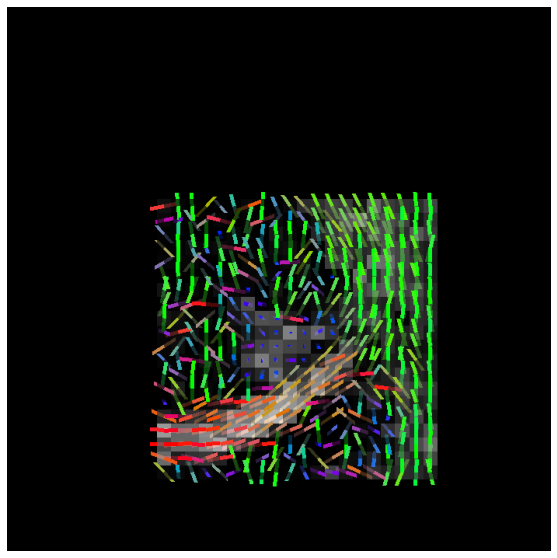

In [18]:
%%time
# MAIN EVOLUTION PROCESS
d = 6
N = 100
T = 10

ball = gaussian_models.G1Ball()
stick = cylinder_models.C1Stick()
bas_model = MultiCompartmentModel(models=[stick, ball])

# IMAGE SELECTION

our_bas_model = {}
voxel_mse = np.zeros([roi['width'], roi['height']])

for x in tqdm.tqdm(range(roi['width'])):
    our_bas_model[x] = {}
    for y in range(roi['height']):

        voxel_signal = data_hcp_roi[x, 0, y, :]
        best_value, best_chromosome, _, _ = es_for_single_voxel(lambda ch: single_voxel_function(ch, bas_model, scheme_hcp, voxel_signal),
                                                         d, N, T, 2*N, 2, 1.0, 1/np.sqrt(2*d), 1/np.sqrt(2*np.sqrt(d)),
                                                         -1, R=domain_dict_to_array(bas_model.parameter_ranges))
#         print(f'Best MSE of voxel x={x},y={y} is {np.round(best_value,4)}')

        our_bas_model[x][y] = set_params_from_chrom(best_chromosome, bas_model, scheme_hcp, voxel_signal)

        voxel_mse[x][y] = our_bas_model[x][y].mean_squared_error(voxel_signal)

print()
print(f'Final MSE: {np.mean(voxel_mse)} and STD: {np.std(voxel_mse)}')
visualize_result(our_bas_model)

100%|██████████| 20/20 [13:33<00:00, 40.68s/it]



Final MSE: 0.0036362734497305503 and STD: 0.0016787119895138375
CPU times: user 13min 9s, sys: 99.3 ms, total: 13min 10s
Wall time: 13min 34s


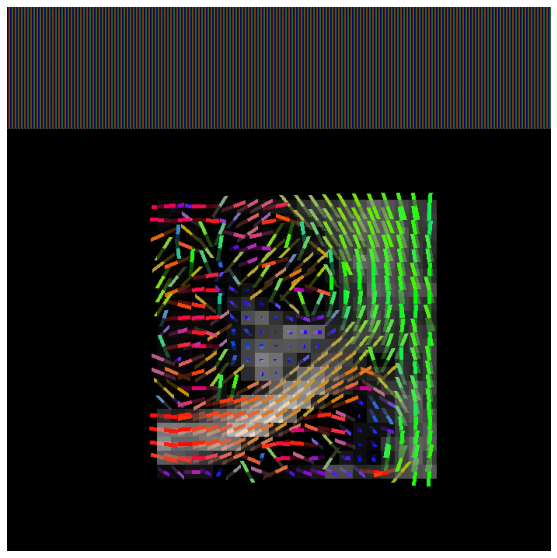

In [19]:
%%time
# MAIN EVOLUTION PROCESS
d = 6
N = 50
T = 50

ball = gaussian_models.G1Ball()
stick = cylinder_models.C1Stick()
bas_model = MultiCompartmentModel(models=[stick, ball])

# IMAGE SELECTION

our_bas_model = {}
voxel_mse = np.zeros([roi['width'], roi['height']])

for x in tqdm.tqdm(range(roi['width'])):
    our_bas_model[x] = {}
    for y in range(roi['height']):

        voxel_signal = data_hcp_roi[x, 0, y, :]
        best_value, best_chromosome, _, _ = es_for_single_voxel(lambda ch: single_voxel_function(ch, bas_model, scheme_hcp, voxel_signal),
                                                         d, N, T, 3*N, 2, 0.2, 1/np.sqrt(2*d), 1/np.sqrt(2*np.sqrt(d)),
                                                         -1, R=domain_dict_to_array(bas_model.parameter_ranges))
#         print(f'Best MSE of voxel x={x},y={y} is {np.round(best_value,4)}')

        our_bas_model[x][y] = set_params_from_chrom(best_chromosome, bas_model, scheme_hcp, voxel_signal)

        voxel_mse[x][y] = our_bas_model[x][y].mean_squared_error(voxel_signal)

print()
print(f'Final MSE: {np.mean(voxel_mse)} and STD: {np.std(voxel_mse)}')
visualize_result(our_bas_model)

### Different ES implementation with "," and "+" modes. Includes some variety of mutation functions

Here is visualization all of them. The other two mutations that are not presented, are connected with controlling individuals out of bounds.

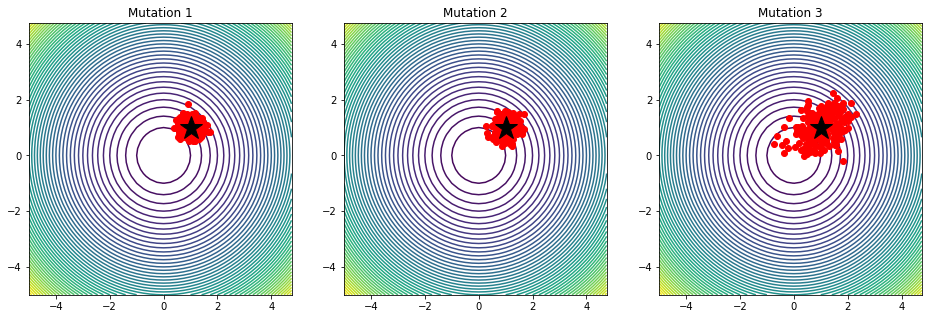

In [96]:
def objective_function_F1(X):
    return - np.sum(X**2, axis=1)

N = 250
d = 2
objective_function = objective_function_F1
original_individual = np.array([[1, 1]])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,5))

sigma = 0.25
mutations = original_individual + sigma * np.random.randn(N, d)
domain_X = np.arange(-5, 5, 0.25)
domain_Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(domain_X, domain_Y)
Z = - objective_function(np.vstack([X.ravel(), Y.ravel()]).T).reshape(X.shape[0], X.shape[1])

# plt.figure(figsize=(9, 9))
ax1.contour(X, Y, Z, 50)
ax1.plot(mutations[:, 0], mutations[:, 1], 'ro')
ax1.plot(original_individual[0, 0], original_individual[0, 1], 'k*', markersize=24)
ax1.set_title('Mutation 1')
# plt.show()

original_individual = np.array([[1, 1]])
sigma = 0.25
S = np.random.uniform(0, sigma, (N,d))
mutations = original_individual + sigma * np.random.randn(N, d)
domain_X = np.arange(-5, 5, 0.25)
domain_Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(domain_X, domain_Y)
Z = - objective_function(np.vstack([X.ravel(), Y.ravel()]).T).reshape(X.shape[0], X.shape[1])

ax2.contour(X, Y, Z, 50)
ax2.plot(mutations[:, 0], mutations[:, 1], 'ro')
ax2.plot(original_individual[0, 0], original_individual[0, 1], 'k*', markersize=24)
ax2.set_title('Mutation 2')

original_individual = np.array([[1, 1]])
sigma = 0.5
S = np.random.uniform(0,sigma, size=(d, d))
S = np.dot(S,S.T)
b = np.dot(np.random.randn(N, d), np.linalg.cholesky(S).T)
mutations += b
domain_X = np.arange(-5, 5, 0.25)
domain_Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(domain_X, domain_Y)
Z = - objective_function(np.vstack([X.ravel(), Y.ravel()]).T).reshape(X.shape[0], X.shape[1])

ax3.contour(X, Y, Z, 50)
ax3.plot(mutations[:, 0], mutations[:, 1], 'ro')
ax3.plot(original_individual[0, 0], original_individual[0, 1], 'k*', markersize=24)
ax3.set_title('Mutation 3')

plt.show()

In [91]:
def set_params_from_chrom(chrom, our_voxel_bas_model, scheme_hcp, voxel_signal):
    our_voxel_bas_model.scheme = scheme_hcp
    S0 = np.mean(voxel_signal[scheme_hcp.b0_mask], axis=-1)
    
    mu_1, mu_2 = chrom[0], chrom[1]
    lambda_parallel = chrom[2] * 1e-09
    lambda_iso = chrom[3] * 1e-09
    f_stick = chrom[4]
    f_ball = chrom[5]
    
    return FittedMultiCompartmentModel(
            our_voxel_bas_model, np.array(S0), np.array([True]), 
            np.array([[mu_1, mu_2, lambda_iso, lambda_parallel, f_stick, f_ball]])
    )


def single_voxel_function(chromosome, bas_model, scheme_hcp, voxel_signal):
    '''
    dla danego chromosomu o dl. 6 wypluwa jego MSE
    '''
    model = set_params_from_chrom(chromosome, bas_model, scheme_hcp, voxel_signal)
    return model.mean_squared_error(voxel_signal)

def domain_dict_to_array(d):
    domains_dict = d
    domains_list = np.array(list(domains_dict.values()))
    domains_array = np.array(domains_list[0][0])
    domains_array = np.vstack((domains_array, domains_list[0][1]))
    domains_array = np.vstack((domains_array, domains_list[1]))
    domains_array = np.vstack((domains_array, domains_list[2]))
    domains_array = np.vstack((domains_array, domains_list[3]))
    domains_array = np.vstack((domains_array, domains_list[4]))
    return domains_array


In [28]:
class ES():
    def __init__(self, R, d, mi, lambda_, F, max_iter=100,learning_rate=0.01,debug=False, ES_type="+",mutation_type="0"):
        self.R = R
        self.d = d
        self.mi = mi # offspring
        self.lambda_ = lambda_ # parents
        self.F = F
        self.current_population = []
        self.current_values = []
        self.max_iter = max_iter
        self.learning_rate = learning_rate
        self.tau0 = learning_rate/np.sqrt(2*np.sqrt(d))
        self.tau = learning_rate/np.sqrt(2*d)
        self.debug = debug
        self.sigma = 0.25
        
        if mutation_type == "0":
            self.mutation = self.mutation0
        if mutation_type == "1":
            self.mutation = self.mutation1
        if mutation_type == "2":
            self.mutation = self.mutation2
        if mutation_type == "3":
            self.mutation = self.mutation3
        if mutation_type == "4":
            self.mutation = self.mutation4
        
        if ES_type == "+":
            self.es_type = '+'
        elif ES_type == ",":
            self.es_type = ','
        else:
            print("Wrong ES type. Try '+' or ','")
        
        self.results = np.array([(0,0,0)])
    
    def in_domain(self, chrom):
        for p in range(len(chrom)):
            if not self.R[p][0] < chrom[p] < self.R[p][1]:
                chrom[p] = np.random.uniform(self.R[p][0],self.R[p][1])
        return chrom
        
    def check_if_in_domain(self, chrom):
        for p in range(len(chrom)):
            if not self.R[p][0] < chrom[p] < self.R[p][1]:
                return False
        return True
        
    def random_population(self):
        self.current_population = np.zeros((self.mi, 2, self.d))
        for pop in range(self.mi):
            for p in range(self.d):
                self.current_population[pop][0][p] = np.random.uniform(self.R[p][0],self.R[p][1])
                self.current_population[pop][1][p] = np.random.uniform(self.R[p][0],self.R[p][1])
        self.current_values = np.zeros((self.mi, 1))
    
    def population_evaluation(self):
        for i,sb in enumerate(self.current_population):
            self.current_values[i] = self.F(sb[0])
            
            
    def parent_selection(self):
        # roulette method
        costs = self.current_values
        costs = costs.reshape(-1)
        fitness_values = costs - costs.min()
        if fitness_values.sum() > 0:
            fitness_values = fitness_values / fitness_values.sum()
        else:
            fitness_values = 1.0 / self.mi * np.ones(self.mi)
        parent_indices = np.random.choice(len(self.current_population), size=(self.mi, self.lambda_), replace=True,p=fitness_values).astype(np.int64)
        children_population = np.zeros((self.mi, 2, self.d))
        
        for i in range(self.mi):
            children_population[i, :, :] = self.current_population[parent_indices[i, :], :, :].mean(axis=0)
        
        return children_population
    
    def mutation0(self, pc):
        # sprawdz czy miesci sie w dziedzinie
        pcc = pc.copy()
        for sb in range(len(pc)):
            addition = np.exp(np.random.normal(0, self.tau ** 2, size=len(pc[sb][1])) + np.random.normal(0, self.tau0 ** 2))
            # taus
            pcc[sb][1] *= addition
            los = pcc[sb][0] + np.random.normal(0, pcc[sb][1] ** 2,size=self.d)
            # jesli ciagle poza dziedzina
            los = self.in_domain(los)
            pcc[sb][0] = los
        return pcc
    
    def mutation1(self, pc):
        for sb in range(len(pc)):
            sigma = 0.25 * self.learning_rate
            pc[sb][0] += sigma * np.random.randn(self.d)
            pc[sb][0] = self.in_domain(pc[sb][0])
        return pc
    
    def mutation2(self, pc):
        sigma = 0.25
        S = np.random.uniform(0, sigma * self.learning_rate, self.d)
        for sb in range(len(pc)):
            pc[sb][0] += S * np.random.randn(self.d)
            pc[sb][0] = self.in_domain(pc[sb][0])
        return pc
    
    def mutation3(self, pc):
        sigma = 0.25 * self.learning_rate
        S = np.random.uniform(0,sigma, size=(self.d, self.d))
        S = np.dot(S,S.T)
        b = np.dot(np.random.randn(self.mi, self.d), np.linalg.cholesky(S).T)
        
        for sb in range(len(pc)):
            pc[sb][0] += b[sb]
            pc[sb][0] = self.in_domain(pc[sb][0])
        return pc
    
    def mutation4(self, pc):
        # sprawdz czy miesci sie w dziedzinie
        pcc = pc.copy()
        for sb in range(len(pc)):
            addition = np.exp(np.random.normal(0, self.tau ** 2, size=len(pc[sb][1])) + np.random.normal(0, self.tau0 ** 2))
            # taus
            pcc[sb][1] *= addition
            
            los = pcc[sb][0] + np.random.normal(0, pcc[sb][1] ** 2,size=self.d)
            for _ in range(3):
                if self.check_if_in_domain(los):
                    break
                los = pcc[sb][0] + np.random.normal(0, pcc[sb][1] ** 2,size=self.d)
                
            los = self.in_domain(los)
            pcc[sb][0] = los
        return pcc
    
    def replacement(self, pc):
        if self.es_type == ",":
            random_indices = np.random.choice(np.arange(0, len(pc)), size=len(self.current_population))
            self.current_population[random_indices] = pc[random_indices]
                
        elif self.es_type == "+":
            all_values = np.append(self.current_values, np.array([self.F(i[0]) for i in pc]))
            all_individuals = np.vstack((self.current_population, pc))
            best_pop_id = np.argsort(all_values)
            self.current_population = all_individuals[best_pop_id[:len(self.current_population)]]
        
    def run(self):
        self.random_population()
        self.population_evaluation()
        
        for i in range(self.max_iter):
            self.learning_rate -= self.learning_rate/(self.max_iter+1)
            if self.mutation == self.mutation0 or self.mutation == self.mutation4:
                self.tau0 = self.learning_rate/np.sqrt(2*np.sqrt(d))
                self.tau = self.learning_rate/np.sqrt(2*d)
            pc = self.parent_selection()
            pc = self.mutation(pc)
            self.replacement(pc)
            self.population_evaluation()
            self.results = np.vstack((self.results, (self.current_values.mean(), self.current_values.min(),self.current_values.max())))
            if self.debug and i%int(self.max_iter/10) == 0:
                print(self.current_values.mean(), self.current_values.min(),self.current_values.max())
        # tu zwrocic najlepszego osobnika z populacji
        self.results = self.results[1:]
        return self.current_population[np.argmin(self.current_values)]

### ES(mi+lambda) mutation tryouts

In [93]:
%%time
mutation_outcomes = {}
for mut in [str(i) for i in np.arange(0,5)]:
    # MAIN EVOLUTION PROCESS
    d = 6
    N = 10
    T = 100

    ball = gaussian_models.G1Ball()
    stick = cylinder_models.C1Stick()
    bas_model = MultiCompartmentModel(models=[stick, ball])

    # IMAGE SELECTION

    our_bas_model = {}
    voxel_mse = np.zeros([roi['width'], roi['height']])

    for x in tqdm.tqdm(range(roi['width'])):
        our_bas_model[x] = {}
        for y in range(roi['height']):

            voxel_signal = data_hcp_roi[x, 0, y, :]
            es_plus = ES(R=domain_dict_to_array(bas_model.parameter_ranges), d=d, mi=N, lambda_=2,
                                                   F=lambda ch: single_voxel_function(ch, bas_model, scheme_hcp, voxel_signal),
                                                   max_iter=T,learning_rate=0.2,debug=False, ES_type="+",mutation_type=mut)
            best_chromosome = es_plus.run()

            our_bas_model[x][y] = set_params_from_chrom(best_chromosome[0], bas_model, scheme_hcp, voxel_signal)

            voxel_mse[x][y] = our_bas_model[x][y].mean_squared_error(voxel_signal)

    print()
    print(f'Final MSE: {np.mean(voxel_mse)} and STD: {np.std(voxel_mse)} for mutation={mut}')
    mutation_outcomes[mut] = np.mean(voxel_mse), np.std(voxel_mse)

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]


Final MSE: 0.005158732557569723 and STD: 0.0029608038329238424 for mutation=0


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]


Final MSE: 0.004823092734485349 and STD: 0.0027636818299541658 for mutation=1


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]


Final MSE: 0.0063381999314657995 and STD: 0.003634951167300646 for mutation=2


LinAlgError: Matrix is not positive definite

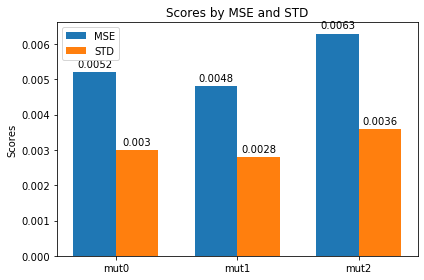

In [94]:
def draw_mutation_outcomes(mutation_outcomes):
    labels = ['mut'+i[0] for i in mutation_outcomes]
    mses = [np.round(i[1][0],4) for i in mutation_outcomes.items()]
    stds = [np.round(i[1][1],4) for i in mutation_outcomes.items()]

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, mses, width, label='MSE')
    rects2 = ax.bar(x + width/2, stds, width, label='STD')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Scores')
    ax.set_title('Scores by MSE and STD')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()


    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')


    autolabel(rects1)
    autolabel(rects2)

    fig.tight_layout()

    plt.show()
    
draw_mutation_outcomes(mutation_outcomes)

### ES(mi,lambda) mutation tryouts

In [48]:
%%time
mutation_outcomes2 = {}
for mut in [str(i) for i in np.arange(0,5)]:
    # MAIN EVOLUTION PROCESS
    d = 6
    N = 10
    T = 100

    ball = gaussian_models.G1Ball()
    stick = cylinder_models.C1Stick()
    bas_model = MultiCompartmentModel(models=[stick, ball])

    # IMAGE SELECTION

    our_bas_model = {}
    voxel_mse = np.zeros([roi['width'], roi['height']])

    for x in tqdm.tqdm(range(roi['width'])):
        our_bas_model[x] = {}
        for y in range(roi['height']):

            voxel_signal = data_hcp_roi[x, 0, y, :]
            es_plus = ES(R=domain_dict_to_array(bas_model.parameter_ranges), d=d, mi=N, lambda_=2,
                                                   F=lambda ch: single_voxel_function(ch, bas_model, scheme_hcp, voxel_signal),
                                                   max_iter=T,learning_rate=0.2,debug=False, ES_type=",",mutation_type=mut)
            best_chromosome = es_plus.run()

            our_bas_model[x][y] = set_params_from_chrom(best_chromosome[0], bas_model, scheme_hcp, voxel_signal)

            voxel_mse[x][y] = our_bas_model[x][y].mean_squared_error(voxel_signal)

    print()
    print(f'Final MSE: {np.mean(voxel_mse)} and STD: {np.std(voxel_mse)} for mutation={mut}')
    mutation_outcomes2[mut] = np.mean(voxel_mse), np.std(voxel_mse)

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]


Final MSE: 0.05239276338804808 and STD: 0.053273057706736994 for mutation=0


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]


Final MSE: 0.050597037801845 and STD: 0.04483340984844982 for mutation=1


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]


Final MSE: 0.11283173243470788 and STD: 0.10423979566544891 for mutation=2


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]


Final MSE: 0.03729736516071071 and STD: 0.02615228691896569 for mutation=3


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [01:33<00:00,  4.68s/it]


Final MSE: 0.0677075209198843 and STD: 0.07872365933471598 for mutation=4
Wall time: 6min 31s


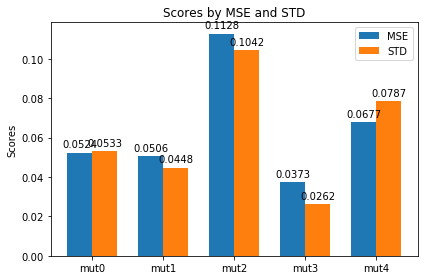

In [49]:
draw_mutation_outcomes(mutation_outcomes2)

### I picked model which performed the best - ES(mi+lambda) with mutation randomly uniformed from (0,sigma) and multiplied by some noise  

In [20]:
%%time
# MAIN EVOLUTION PROCESS
d = 6
N = 20
T = 200

ball = gaussian_models.G1Ball()
stick = cylinder_models.C1Stick()
bas_model = MultiCompartmentModel(models=[stick, ball])

# IMAGE SELECTION

our_bas_model = {}
voxel_mse = np.zeros([roi['width'], roi['height']])

for x in tqdm.tqdm(range(roi['width'])):
    our_bas_model[x] = {}
    for y in range(roi['height']):

        voxel_signal = data_hcp_roi[x, 0, y, :]
        es_plus = ES(R=domain_dict_to_array(bas_model.parameter_ranges), d=d, mi=N, lambda_=2,
                                               F=lambda ch: single_voxel_function(ch, bas_model, scheme_hcp, voxel_signal),
                                               max_iter=T,learning_rate=1,debug=False, ES_type="+",mutation_type="2")
        best_chromosome = es_plus.run()

        our_bas_model[x][y] = set_params_from_chrom(best_chromosome[0], bas_model, scheme_hcp, voxel_signal)

        voxel_mse[x][y] = our_bas_model[x][y].mean_squared_error(voxel_signal)

print()
print(f'Final MSE: {np.mean(voxel_mse)} and STD: {np.std(voxel_mse)}')
visualize_result(our_bas_model)

  0%|          | 0/20 [00:00<?, ?it/s]


NameError: name 'ES' is not defined

### CMA-ES implementation

In [21]:
class CMA_ES():
    def __init__(self, R, F, d, mi, lambda_, max_iter=100):
        self.d = d
        self.mi = mi
        self.lambda_ = lambda_ # offspring/population_size
        self.sigma = 1 # 0.3 # step size
        self.R = R
        self.m = self.in_domain(np.zeros(self.d)-100)
        self.C = np.identity(self.d)
        self.p_sigma = 0 # (isotropic evolution path)
        self.p_C = 0 # (anisotropic evolution path)
        self.F = F
        self.max_iter = max_iter
        
        self.R = R
        self.current_population = np.zeros((self.lambda_, self.d))
        self.current_values = np.zeros(self.lambda_)
        
        self.previous_cost = 100
        
        self.init()
        
    def init(self):
        self.weights = np.log(self.mi+1/2) - np.log(np.arange(1.0, self.mi+1)).T
        self.weights = self.weights/np.sum(self.weights)
        self.mueff = np.sum(self.weights)**2/np.sum(self.weights**2)
        
        self.cc = (4+self.mueff/self.d) / (self.d+4 + 2*self.mueff/self.d);
        self.cs = (self.mueff+2) / (self.d+self.mueff+5)
        self.c1 = 2 / ((self.d+1.3)**2+self.mueff)
        self.cmu = min(1.0 - self.c1, 2 * (self.mueff - 2 + 1/self.mueff) / ((self.d+2)**2+self.mueff))
        self.damps = 1 + 2*max(0, np.sqrt((self.mueff-1)/(self.d+1))-1) + self.cs
        
        self.pc = np.zeros((self.d,1))
        self.ps = np.zeros((self.d,1))
        B = np.eye(self.d)
        D = np.ones((self.d,1))
        self.invsqrtC = B * np.diag(np.linalg.inv(B)) * B.T
        eigeneval = 0
        self.chiN=self.d**0.5 *(1 - 1/(4*self.d) + 1/(21*self.d**2))
    
    def in_domain(self, chrom):
        for p in range(len(chrom)):
            if not self.R[p][0] < chrom[p] < self.R[p][1]:
                chrom[p] = np.random.uniform(self.R[p][0],self.R[p][1])
        return chrom
            
    def selection(self):        
        for pop in range(self.lambda_):
            self.current_population[pop] = np.random.multivariate_normal(self.m,self.sigma**2 * self.C)
            self.current_population[pop] = self.in_domain(self.current_population[pop])
        
    
    def population_evaluation(self):
        for i,sb in enumerate(self.current_population):
            self.current_values[i] = self.F(sb)

        
    def run(self):
        for i in range(self.max_iter):
            self.selection()
            self.population_evaluation()
            self.current_population[np.argsort(-self.current_values)]
            self.current_values = np.sort(-self.current_values)
            self.previous_cost = self.m
            self.m = np.dot(self.weights,self.current_population[:self.mi])
            
            self.ps = (1-self.cs)*self.ps+ np.sqrt(self.cs*(2-self.cs)*self.mueff)*self.invsqrtC * (self.m - self.previous_cost) / self.sigma
            hsig = np.linalg.norm(self.ps)/np.sqrt(1-(1-self.cs)**(2*i/self.lambda_))/self.chiN < 1.4 + 2/(self.d+1)
            self.pc = (1-self.cc)*self.pc+ hsig * np.sqrt(self.cc*(2-self.cc)*self.mueff) * (self.m - self.previous_cost) / self.sigma

            artmp = (1/self.sigma) * (self.current_population[:self.mi] - np.matlib.repmat(np.array([self.previous_cost]).T,1,self.mi).T)

            self.C = (1-self.c1-self.cmu) * self.C + self.c1 * (self.pc*self.pc.T + (1-hsig) * self.cc*(2-self.cc) * self.C) + self.cmu * np.dot(np.dot(artmp.T, np.diag(self.weights)), artmp)
            
            self.sigma = self.sigma * np.exp((self.cs/self.damps)*(np.linalg.norm(self.ps)/self.chiN - 1))

        return self.current_population[np.argmin(self.current_values)]

100%|██████████| 20/20 [24:40<00:00, 74.04s/it]



Final MSE: 0.04867326312014363 and STD: 0.026795826302434336
CPU times: user 23min 44s, sys: 305 ms, total: 23min 45s
Wall time: 24min 41s


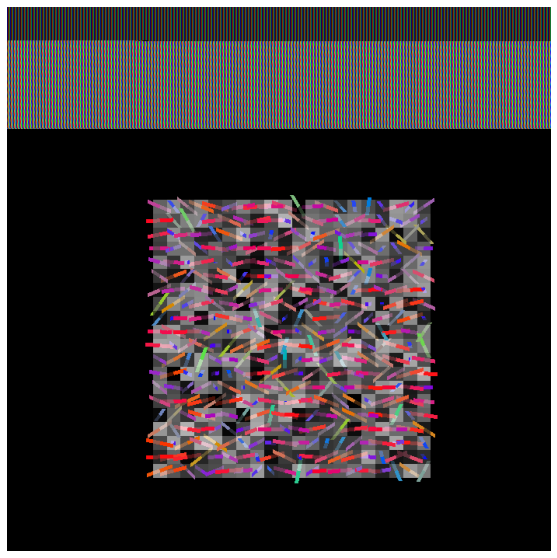

In [22]:
%%time
# MAIN EVOLUTION PROCESS
d = 6
N = 20
T = 200

ball = gaussian_models.G1Ball()
stick = cylinder_models.C1Stick()
bas_model = MultiCompartmentModel(models=[stick, ball])

# IMAGE SELECTION

our_bas_model = {}
voxel_mse = np.zeros([roi['width'], roi['height']])

for x in tqdm.tqdm(range(roi['width'])):
    our_bas_model[x] = {}
    for y in range(roi['height']):

        voxel_signal = data_hcp_roi[x, 0, y, :]
        es_plus = CMA_ES(R=domain_dict_to_array(bas_model.parameter_ranges), d=d, mi=N, lambda_=2*N,
                                               F=lambda ch: single_voxel_function(ch, bas_model, scheme_hcp, voxel_signal),
                                               max_iter=T)
        best_chromosome = es_plus.run()

        our_bas_model[x][y] = set_params_from_chrom(best_chromosome, bas_model, scheme_hcp, voxel_signal)

        voxel_mse[x][y] = our_bas_model[x][y].mean_squared_error(voxel_signal)

print()
print(f'Final MSE: {np.mean(voxel_mse)} and STD: {np.std(voxel_mse)}')
visualize_result(our_bas_model)

### Since CMA-ES performed poorly, I switched to ES(1+1)

In [23]:
class ES_11():
    def __init__(self, R, d, k, F, max_iter=100):
        self.R = R
        self.d = d
        self.F = F
        self.k = k
        self.current_population = np.zeros(self.d)
        self.current_sigmas = np.zeros(self.d)
        self.current_values = 0
        self.max_iter = max_iter
        self.tau1 = 1/0.82
        self.tau2 = 0.82
        
        self.mutation_succ = 0
    
    def in_domain(self, chrom):
        for p in range(len(chrom)):
            if not self.R[p][0] < chrom[p] < self.R[p][1]:
                chrom[p] = np.random.uniform(self.R[p][0],self.R[p][1])
        return chrom
        
    def check_if_in_domain(self, chrom):
        for p in range(len(chrom)):
            if not self.R[p][0] < chrom[p] < self.R[p][1]:
                return False
        return True
    
    def random_population(self):
        for p in range(self.d):
            self.current_population[p] = np.random.uniform(self.R[p][0],self.R[p][1])
            self.current_sigmas[p] = np.random.uniform(self.R[p][0],self.R[p][1])
    
    def population_evaluation(self, x):
        return self.F(x)

    def mutation(self):
        y = np.zeros(self.d)
        for p in range(self.d):
            y[p] = self.current_population[p] + np.random.normal(0,np.abs(self.current_sigmas[p]))
        return y
    
    def sigma_update(self):
        if self.mutation_succ > 1/5*k:
            self.current_sigmas *= self.tau1
        elif self.mutation_succ < 1/5*k:
            self.current_sigmas *= self.tau2
        self.mutation_succ = 0
        
    def run(self):
        self.random_population()
        self.current_value = self.population_evaluation(self.current_population)
        
        for i in range(self.max_iter):
            y = self.mutation()
            y_value = self.population_evaluation(y)
            if y_value <= self.current_value:
                self.current_population = y
                self.mutation_succ += 1
            if i % k == 0:
                self.sigma_update()
        return self.current_population

100%|██████████| 20/20 [22:55<00:00, 68.77s/it]



Final MSE: 0.07660680376959794 and STD: 0.10176854768355005
CPU times: user 22min 32s, sys: 242 ms, total: 22min 33s
Wall time: 22min 56s


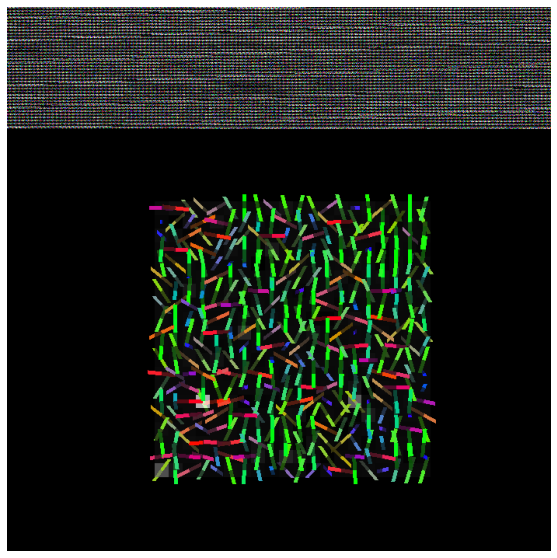

In [24]:
%%time
# MAIN EVOLUTION PROCESS
d = 6
T = 10000
k = 50

ball = gaussian_models.G1Ball()
stick = cylinder_models.C1Stick()
bas_model = MultiCompartmentModel(models=[stick, ball])

# IMAGE SELECTION

our_bas_model = {}
voxel_mse = np.zeros([roi['width'], roi['height']])

for x in tqdm.tqdm(range(roi['width'])):
    our_bas_model[x] = {}
    for y in range(roi['height']):

        voxel_signal = data_hcp_roi[x, 0, y, :]
        es_11 = ES_11(R=domain_dict_to_array(bas_model.parameter_ranges), d=d, k=k,
                                               F=lambda ch: single_voxel_function(ch, bas_model, scheme_hcp, voxel_signal),
                                               max_iter=T)
        best_chromosome = es_11.run()

        our_bas_model[x][y] = set_params_from_chrom(best_chromosome, bas_model, scheme_hcp, voxel_signal)

        voxel_mse[x][y] = our_bas_model[x][y].mean_squared_error(voxel_signal)

print()
print(f'Final MSE: {np.mean(voxel_mse)} and STD: {np.std(voxel_mse)}')
visualize_result(our_bas_model)

### ES(1+1) also performed badly which was easy to predict.

### It's time to tune the best solution.

In [25]:
%%time
# MAIN EVOLUTION PROCESS
d = 6
N = 20
T = 200

ball = gaussian_models.G1Ball()
stick = cylinder_models.C1Stick()
bas_model = MultiCompartmentModel(models=[stick, ball])

# IMAGE SELECTION

our_bas_model = {}
voxel_mse = np.zeros([roi['width'], roi['height']])

for x in tqdm.tqdm(range(roi['width'])):
    our_bas_model[x] = {}
    for y in range(roi['height']):

        voxel_signal = data_hcp_roi[x, 0, y, :]
        es_plus = ES(R=domain_dict_to_array(bas_model.parameter_ranges), d=d, mi=N, lambda_=2,
                                               F=lambda ch: single_voxel_function(ch, bas_model, scheme_hcp, voxel_signal),
                                               max_iter=T,learning_rate=1,debug=False, ES_type="+",mutation_type="2")
        best_chromosome = es_plus.run()

        our_bas_model[x][y] = set_params_from_chrom(best_chromosome[0], bas_model, scheme_hcp, voxel_signal)

        voxel_mse[x][y] = our_bas_model[x][y].mean_squared_error(voxel_signal)

print()
print(f'Final MSE: {np.mean(voxel_mse)} and STD: {np.std(voxel_mse)}')
visualize_result(our_bas_model)

  0%|          | 0/20 [00:00<?, ?it/s]


NameError: name 'ES' is not defined

### How evolution performs when I let it go over constraints of domain and punish it every time when it goes over domain.

In [34]:
class ES_without_constraints():
    def __init__(self, R, d, mi, lambda_, F, max_iter=100,learning_rate=0.01, ES_type="+",mutation_type="2"):
        self.R = R
        self.d = d
        self.mi = mi # offspring
        self.lambda_ = lambda_ # parents
        self.F = F
        self.current_population = []
        self.current_values = []
        self.max_iter = max_iter
        self.learning_rate = learning_rate
        self.sigma = 0.25
        
        if mutation_type == "1":
            self.mutation = self.mutation1
        if mutation_type == "2":
            self.mutation = self.mutation2
        if mutation_type == "3":
            self.mutation = self.mutation3
        
        if ES_type == "+":
            self.es_type = '+'
        elif ES_type == ",":
            self.es_type = ','
        else:
            print("Wrong ES type. Try '+' or ','")
        
    def random_population(self):
        self.current_population = np.zeros((self.mi, 2, self.d))
        for pop in range(self.mi):
            for p in range(self.d):
                self.current_population[pop][0][p] = np.random.uniform(self.R[p][0],self.R[p][1])
                self.current_population[pop][1][p] = np.random.uniform(self.R[p][0],self.R[p][1])
        self.current_values = np.zeros((self.mi, 1))
    
    def population_evaluation(self):
        for i,sb in enumerate(self.current_population):
            self.current_values[i] = self.F(sb[0])
            
            
    def parent_selection(self):
        # roulette method
        costs = self.current_values
        costs = costs.reshape(-1)
        fitness_values = costs - costs.min()
        if fitness_values.sum() > 0:
            fitness_values = fitness_values / fitness_values.sum()
        else:
            fitness_values = 1.0 / self.mi * np.ones(self.mi)
        parent_indices = np.random.choice(len(self.current_population), size=(self.mi, self.lambda_), replace=True,p=fitness_values).astype(np.int64)
        children_population = np.zeros((self.mi, 2, self.d))
        
        for i in range(self.mi):
            children_population[i, :, :] = self.current_population[parent_indices[i, :], :, :].mean(axis=0)
        
        return children_population
    
    def mutation1(self, pc):
        for sb in range(len(pc)):
            sigma = 0.25 * self.learning_rate
            pc[sb][0] += sigma * np.random.randn(self.d)
        return pc
    
    def mutation2(self, pc):
        sigma = 0.25
        S = np.random.uniform(0, sigma * self.learning_rate, self.d)
        for sb in range(len(pc)):
            pc[sb][0] += S * np.random.randn(self.d)
        return pc
    
    def mutation3(self, pc):
        sigma = 0.25 * self.learning_rate
        S = np.random.uniform(0,sigma, size=(self.d, self.d))
        S = np.dot(S,S.T)
        b = np.dot(np.random.randn(self.mi, self.d), np.linalg.cholesky(S).T)
        
        for sb in range(len(pc)):
            pc[sb][0] += b[sb]
            pc[sb][0] = self.in_domain(pc[sb][0])
        return pc
    
    def replacement(self, pc):
        if self.es_type == ",":
            random_indices = np.random.choice(np.arange(0, len(pc)), size=len(self.current_population))
            self.current_population[random_indices] = pc[random_indices]
                
        elif self.es_type == "+":
            all_values = np.append(self.current_values, np.array([self.F(i[0]) for i in pc]))
            all_individuals = np.vstack((self.current_population, pc))
            best_pop_id = np.argsort(all_values)
            self.current_population = all_individuals[best_pop_id[:len(self.current_population)]]
        
    def run(self):
        self.random_population()
        self.population_evaluation()
        
        for i in range(self.max_iter):
            self.learning_rate -= self.learning_rate/(self.max_iter+1)
            pc = self.parent_selection()
            pc = self.mutation(pc)
            self.replacement(pc)
            self.population_evaluation()
        return self.current_population[np.argmin(self.current_values)]

In [35]:
def single_voxel_function_without_constraints(chromosome, bas_model, scheme_hcp, voxel_signal,R,multiplier=1):
    '''
    for certain chromosome of length 6, returns its MSE and punishment for leaving the domain
    '''
    punishment = 0
    for p in range(len(chromosome)):
            if R[p][0] > chromosome[p]:
                punishment += R[p][0] - chromosome[p]
            elif chromosome[p] > R[p][1]:
                punishment += chromosome[p] - R[p][1]
    
    model = set_params_from_chrom(chromosome, bas_model, scheme_hcp, voxel_signal)
    return model.mean_squared_error(voxel_signal) + punishment*multiplier

In [72]:
%%time

multipliers = {}
for mul in np.arange(1,5):
    # MAIN EVOLUTION PROCESS
    d = 6
    N = 20
    T = 200

    ball = gaussian_models.G1Ball()
    stick = cylinder_models.C1Stick()
    bas_model = MultiCompartmentModel(models=[stick, ball])

    R = domain_dict_to_array(bas_model.parameter_ranges)

    # IMAGE SELECTION

    our_bas_model = {}
    voxel_mse = np.zeros([roi['width'], roi['height']])

    for x in tqdm.tqdm(range(roi['width'])):
        our_bas_model[x] = {}
        for y in range(roi['height']):

            voxel_signal = data_hcp_roi[x, 0, y, :]
            es_w = ES_without_constraints(R=R, d=d, mi=N, lambda_=2,F=lambda ch: single_voxel_function_without_constraints(ch, bas_model, scheme_hcp, voxel_signal,R=R,multiplier=mul),
                                          max_iter=T,learning_rate=1, ES_type="+",mutation_type="2")
            best_chromosome = es_w.run()

            our_bas_model[x][y] = set_params_from_chrom(best_chromosome[0], bas_model, scheme_hcp, voxel_signal)

            voxel_mse[x][y] = our_bas_model[x][y].mean_squared_error(voxel_signal)

    print()
    print(f'Final MSE: {np.mean(voxel_mse)} and STD: {np.std(voxel_mse)}')
    multipliers[mul] = np.mean(voxel_mse), np.std(voxel_mse)

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]


Final MSE: 0.0034095249946047767 and STD: 0.0017130568042383909


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]


Final MSE: 0.0034057243944931458 and STD: 0.0017529930074658905


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]


Final MSE: 0.0033949068256493866 and STD: 0.001690108928855771


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [08:05<00:00, 24.26s/it]


Final MSE: 0.0033668985183589817 and STD: 0.0017329697667539858
Wall time: 31min 51s


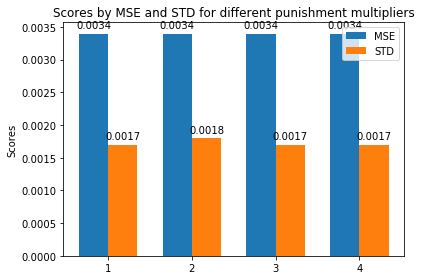

In [73]:
labels = [i[0] for i in multipliers.items()]
mses = [np.round(i[1][0],4) for i in multipliers.items()]
stds = [np.round(i[1][1],4) for i in multipliers.items()]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, mses, width, label='MSE')
rects2 = ax.bar(x + width/2, stds, width, label='STD')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by MSE and STD for different punishment multipliers')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()

### Final model and result

- At first I tried to solve whole problem at once, which mean that my input were set of all pixels in ROI, each having 6 parameters. I used basic implementation of ES(mi+lambda) algorithm with noise addition as mutation method and offspring population generated by Global Intermediere Recombination.
- Then I divided this problem into smaller subproblems, by calculating MSE from each voxel separatly.
- I've tested variety of mutations on both ES(mi+lambda) and ES(mi,lambda) and chosen the one performing the best. Later on I'm sticking to that one certain mutation. During testing procces, I realized that those evoultion strategies perform better when $\mu$ or N are relatively small and number of iterations is few times bigger. It's also better to have $\lambda$ equal 2, because higher number of parents results in smaller diversity between samples.
- 

100%|██████████| 20/20 [23:11<00:00, 69.57s/it]



Final MSE: 0.003266820999364553 and STD: 0.0016947207150488953
CPU times: user 22min 58s, sys: 156 ms, total: 22min 58s
Wall time: 23min 12s


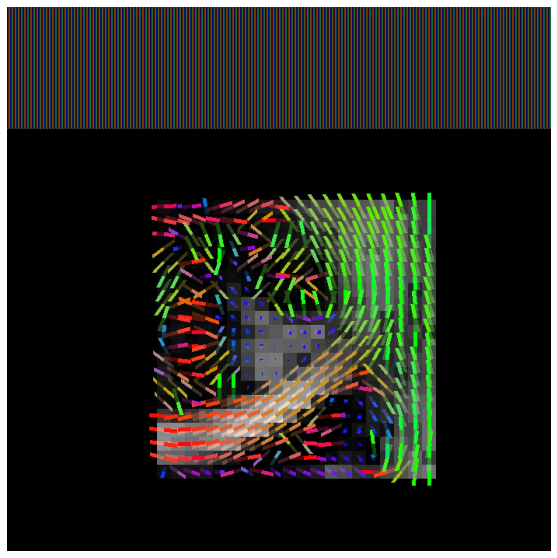

In [29]:
%%time
# MAIN EVOLUTION PROCESS
d = 6
N = 20
T = 300

ball = gaussian_models.G1Ball()
stick = cylinder_models.C1Stick()
bas_model = MultiCompartmentModel(models=[stick, ball])

# IMAGE SELECTION

our_bas_model = {}
voxel_mse = np.zeros([roi['width'], roi['height']])

for x in tqdm.tqdm(range(roi['width'])):
    our_bas_model[x] = {}
    for y in range(roi['height']):

        voxel_signal = data_hcp_roi[x, 0, y, :]
        es_plus = ES(R=domain_dict_to_array(bas_model.parameter_ranges), d=d, mi=N, lambda_=2,
                                               F=lambda ch: single_voxel_function(ch, bas_model, scheme_hcp, voxel_signal),
                                               max_iter=T,learning_rate=1,debug=False, ES_type="+",mutation_type="2")
        best_chromosome = es_plus.run()

        our_bas_model[x][y] = set_params_from_chrom(best_chromosome[0], bas_model, scheme_hcp, voxel_signal)

        voxel_mse[x][y] = our_bas_model[x][y].mean_squared_error(voxel_signal)

print()
print(f'Final MSE: {np.mean(voxel_mse)} and STD: {np.std(voxel_mse)}')
visualize_result(our_bas_model)

100%|██████████| 20/20 [24:38<00:00, 73.93s/it]



Final MSE: 0.0033288018207294494 and STD: 0.0017324810120049243
CPU times: user 24min 19s, sys: 246 ms, total: 24min 19s
Wall time: 24min 39s


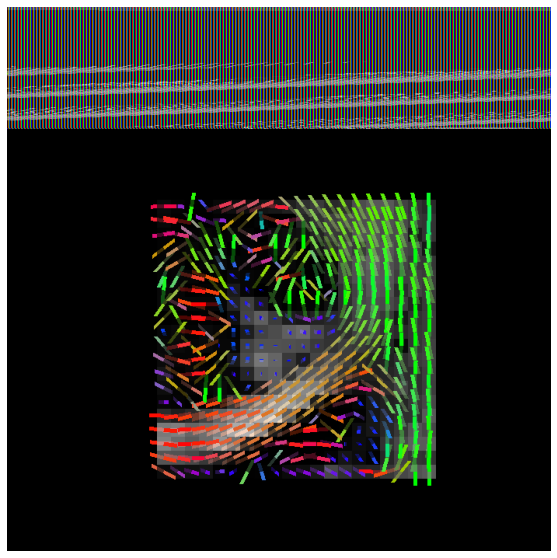

In [37]:
%%time
# MAIN EVOLUTION PROCESS
d = 6
N = 20
T = 300

ball = gaussian_models.G1Ball()
stick = cylinder_models.C1Stick()
bas_model = MultiCompartmentModel(models=[stick, ball])

R = domain_dict_to_array(bas_model.parameter_ranges)
# IMAGE SELECTION

our_bas_model = {}
voxel_mse = np.zeros([roi['width'], roi['height']])

for x in tqdm.tqdm(range(roi['width'])):
    our_bas_model[x] = {}
    for y in range(roi['height']):

        voxel_signal = data_hcp_roi[x, 0, y, :]
        es_w = ES_without_constraints(R=R, d=d, mi=N, lambda_=2,F=lambda ch: single_voxel_function_without_constraints(ch, bas_model, scheme_hcp, voxel_signal,R=R,multiplier=1),
                                          max_iter=T,learning_rate=1, ES_type="+",mutation_type="2")
        best_chromosome = es_w.run()

        our_bas_model[x][y] = set_params_from_chrom(best_chromosome[0], bas_model, scheme_hcp, voxel_signal)

        voxel_mse[x][y] = our_bas_model[x][y].mean_squared_error(voxel_signal)

print()
print(f'Final MSE: {np.mean(voxel_mse)} and STD: {np.std(voxel_mse)}')
visualize_result(our_bas_model)